## Autoencoder model
Below there is an implementation of the class, that will obtain loss from output of decoder and from latent space as well.

In [0]:
# imports
import sklearn.datasets as sk_data
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from IPython import display

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.utils.data as torch_data

### First dataset.
Here is first dataset, which has 2 classes

In [38]:
cancer_dset = sk_data.load_breast_cancer()

X = StandardScaler().fit_transform(cancer_dset['data'])

print('Features: ', list(cancer_dset['feature_names']))
print('\nShape:', X.shape)

X_train, X_val, y_train, y_val = train_test_split(X, cancer_dset['target'], test_size=0.2, random_state=42)
print('\nTrain size: ', len(X_train))
print('Validation size: ', len(X_val))

Features:  ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'mean fractal dimension', 'radius error', 'texture error', 'perimeter error', 'area error', 'smoothness error', 'compactness error', 'concavity error', 'concave points error', 'symmetry error', 'fractal dimension error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry', 'worst fractal dimension']

Shape: (569, 30)

Train size:  455
Validation size:  114


In [0]:
class CancerData(torch_data.Dataset):
    def __init__(self, X, y):
        super(CancerData, self).__init__()
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], requires_grad=False), torch.tensor(self.y[idx], requires_grad=False)

In [40]:
train_dset = CancerData(X_train, y_train) 
val_dset = CancerData(X_val, y_val) 

print(train_dset[5])

(tensor([ 0.1172,  1.9199,  0.1961,  0.0111,  1.2482,  1.0453,  0.9429,  0.6376,
         1.7940,  1.1302, -0.1269, -0.3336,  0.0064, -0.1713, -0.4780,  0.9458,
         0.5145, -0.1454, -0.2388,  0.6321,  0.2466,  1.8650,  0.5016,  0.1101,
         1.5532,  2.5664,  2.0649,  0.8617,  2.1310,  2.7793]), tensor(0.))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


#### Autoencoder class

Note that output is tuple: (latent output, decoder output)

In [0]:
class AE_model(nn.Module):
    def __init__(self, encoder, decoder):
        super(AE_model, self).__init__()
        # encoder and decoder could be of any architecture
        self.encoder = encoder 
        self.decoder = decoder
    
    def forward(self, x):
        """
        Take a mini-batch as an input, encode it to the latent space and decode back to the original space
        x_out = decoder(encoder(x))
        :param x: torch.tensor, (MB, x_dim)
        :return: torch.tensor, (MB, x_dim)
        """
        x_latent = self.encoder(x)
        x_out = self.decoder(x_latent)
        return (x_latent, x_out)

#### Some encoder-decoder architectures.

In [0]:
n_features = X.shape[1]
slope=0.1
encoder = lambda x: nn.Sequential(torch.nn.Linear(n_features, 50, bias=True), torch.nn.LeakyReLU(negative_slope=slope),
                                  torch.nn.Linear(50, 10, bias=True), torch.nn.LeakyReLU(negative_slope=slope), torch.nn.Dropout(0.1), 
                                  torch.nn.Linear(10, x), torch.nn.Tanh()             
                        )  

decoder = lambda x: nn.Sequential(torch.nn.Linear(x, 10), torch.nn.LeakyReLU(negative_slope=slope), 
                                  torch.nn.Linear(10, 50), torch.nn.LeakyReLU(negative_slope=slope), torch.nn.Dropout(0.1),
                                  torch.nn.Linear(50, n_features), 
                        )

#### Initilizing everything for train

In [43]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'device: {device}')

net = AE_model(encoder(2), decoder(2))  
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(params=net.parameters(), lr=5*1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)

train_loader = torch_data.DataLoader(train_dset, batch_size=2, shuffle=True) 
val_loader = torch_data.DataLoader(val_dset, batch_size=200, shuffle=False) 

device: cuda


In [0]:
def to_one_hot(y_array, nb_digits=10):
    # y_array is torch tensor od shape (batch_size, 1)
    batch_size = y_array.shape[0]
    y_array = y_array.view(-1, 1).type(torch.LongTensor)
    y_onehot = torch.FloatTensor(batch_size, nb_digits)
    y_onehot.zero_()
    y_onehot -= 1
    y_onehot.scatter_(1, y_array, 1)
    return y_onehot

#### Train function
Note that it takes into account the fact, that model output is tuple.

In [0]:
def train(epochs, net, criterion, optimizer, train_loader, val_loader, nb_digits_latent,
          scheduler=None, verbose=True, save_dir=None, baseline=None, device='cuda'):
    net.to(device)
    train_losses = []
    val_losses = []
    epoch_list = []
    freq = max(epochs//100, 1)
    for epoch in range(1, epochs+1):
        net.train()
        train_loss = []
        for X_train, y_train in train_loader:
            X_train = X_train.to(device)
            # Perform one step of minibatch stochastic gradient descent
            net_latent, net_output = net.forward(X_train)
            loss = criterion(net_output, X_train)
            latent_true = to_one_hot(y_train, nb_digits=nb_digits_latent)
            latent_true = latent_true.to(device)
            loss += criterion(net_latent, latent_true)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            del X_train # to release memory
        train_losses.append( np.mean(train_loss) )

        # define NN evaluation, i.e. turn off dropouts, batchnorms, etc.
        net.eval()
        for X_val, _ in val_loader:
            # Compute the validation loss
            X_val = X_val.to(device)
            net_output = net.forward(X_val)[1]
            val_loss = criterion(net_output, X_val)
            del X_val # to release memory
        val_losses.append( val_loss )
        epoch_list.append(epoch)

        if scheduler is not None:
            scheduler.step()
        
        if verbose and epoch%freq==0:
            
            display.clear_output(wait=True)
            f, axes = plt.subplots(1, 1, figsize=(8, 6))
            axes.set_title('Loss', fontsize=20)
            axes.plot(epoch_list, train_losses, label='train')
            axes.plot(epoch_list, val_losses, label='val')
            axes.set_xlabel('epoch', fontsize=15)
            axes.set_ylabel('MSE', fontsize=15)
            axes.grid(True)
            if baseline:
                axes.axhline(baseline, c='r', label='baseline')

            axes.legend(fontsize=15)
            plt.tight_layout()
            plt.show()

            #print('Epoch {}/{} || Loss:  Train {:.4f} | Validation {:.4f}'.format(epoch, epochs, np.mean(train_loss), val_loss))


#### Training the model. 
We have loss from latent and from decoder as well.

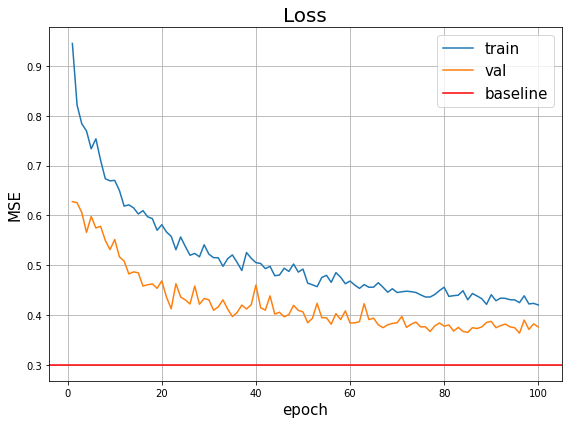

In [51]:
# for `MSE` loss get < 0.28 on validation, with AE "bottleneck" = 2
train(100, net, criterion, optimizer, train_loader, val_loader, nb_digits_latent=2 ,scheduler=scheduler, verbose=True, baseline=0.3, device=device) 

#### Latent visualization

Here we show, that our encoder is a good classificator:)

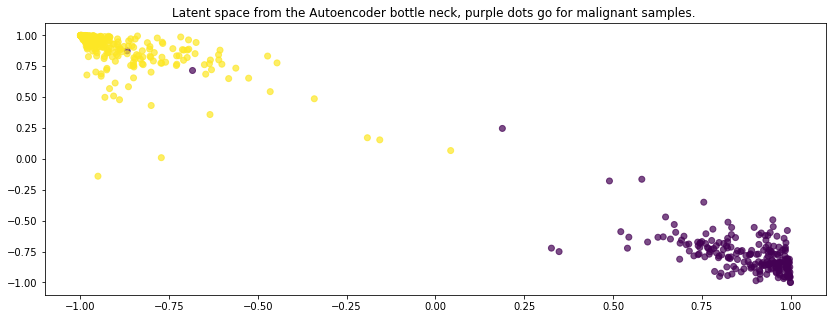

In [52]:
 ### BEGIN Solution
plt.figure(figsize=(14, 5))
net.eval()
enc = net.encoder(torch.tensor(X, requires_grad=False, dtype=torch.float, device=device)).cpu().detach()
plt.scatter(enc[:,0], enc[:,1], c=cancer_dset['target'], alpha=0.7);
plt.title('Latent space from the Autoencoder bottle neck, purple dots go for malignant samples. ');
 ### END Solution

### Second dataset
Here is kMNIST, which has 10 classes.


In [0]:
def load(f):
    return np.load(f)['arr_0']

# Load the data
x_train = load('data/kmnist/kmnist-train-imgs.npz')
x_test = load('data/kmnist/kmnist-test-imgs.npz')
y_train = load('data/kmnist/kmnist-train-labels.npz')
y_test = load('data/kmnist/kmnist-test-labels.npz')

# Reshape the data and scale
train_size = x_train.shape[0]
x_train = x_train.reshape(train_size, 1, 28, 28)/255.

test_size = x_test.shape[0]
x_test = x_test.reshape(test_size, 1, 28, 28)/255.

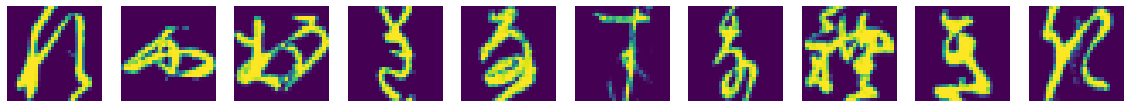

In [56]:
fig, ax = plt.subplots(ncols=10, figsize=(20, 5))
for i in range(10):
    ax[i].imshow(x_train[i].reshape(28,28));
    ax[i].axis('off')

In [0]:
class kMNISTData(torch_data.Dataset):
    def __init__(self, X, y):
        super(kMNISTData, self).__init__()
        self.X = torch.tensor(X, dtype=torch.float32, requires_grad=False)                                                     
        self.y = torch.tensor(y, dtype=torch.float32, requires_grad=False)
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [0]:
train_kmnist = kMNISTData(x_train, y_train) 
test_kmnist = kMNISTData(x_test, y_test) 

#### Encoder-decoder architecture.

In [0]:
class View(torch.nn.Module):
    def __init__(self, out_shape):
        super().__init__()
        self.out_shape = out_shape
    def forward(self, input):
        return input.view(*self.out_shape)

In [0]:
encoder = lambda bottle_dim: nn.Sequential(
    torch.nn.Conv2d(in_channels=1, out_channels=5, kernel_size=7), 
    torch.nn.BatchNorm2d(5), torch.nn.ReLU(), # (5, 22, 22)
    torch.nn.MaxPool2d(kernel_size=2, stride=2), 
    torch.nn.BatchNorm2d(5), torch.nn.Dropout(p=0.02), # (5, 11, 11)
    torch.nn.Conv2d(in_channels=5, out_channels=3, kernel_size=3), 
    torch.nn.BatchNorm2d(3), torch.nn.ReLU(), # (3, 9, 9) 
    torch.nn.Flatten(), # (3*9*9)
    torch.nn.Linear(3*9*9, bottle_dim), torch.nn.Tanh()
    ) 

decoder = lambda bottle_dim: nn.Sequential( 
    torch.nn.Linear(bottle_dim, 3*9*9), View(out_shape=(-1, 3, 9, 9)),
    torch.nn.ConvTranspose2d(in_channels=3, out_channels=5, kernel_size=3), 
    torch.nn.BatchNorm2d(5), torch.nn.ReLU(), torch.nn.Dropout(p=0.02), # (5, 11, 11)
    torch.nn.ConvTranspose2d(in_channels=5, out_channels=5, kernel_size=12), torch.nn.BatchNorm2d(5), torch.nn.ReLU(),
    torch.nn.ConvTranspose2d(in_channels=5, out_channels=1, kernel_size=7), torch.nn.Sigmoid()
    ) 

#### Train initialization.

In [62]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'device: {device}')

net = AE_model(encoder(10), decoder(10)) 
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(params=net.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9)

train_loader = torch_data.DataLoader(train_kmnist, batch_size=100, shuffle=True) 
val_loader = torch_data.DataLoader(test_kmnist, batch_size=100, shuffle=False) 

device: cuda


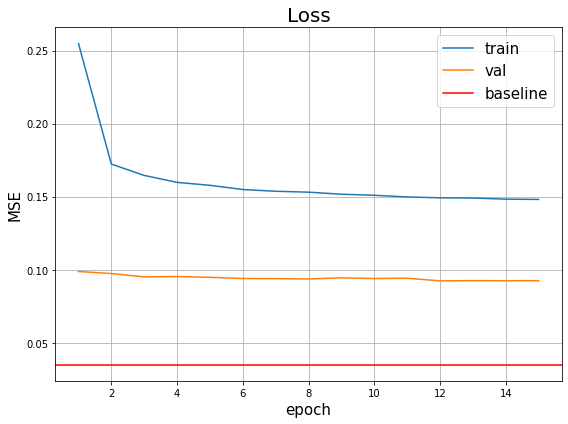

In [63]:
epochs = 15
train(epochs, net, criterion, optimizer, train_loader, val_loader, nb_digits_latent=10, 
      scheduler=scheduler, verbose=True, baseline=0.035)

#### Latent visualization

Here we do PCA on 10-dimensional latent representation.

In [0]:
### BEGIN Solution

x_whole_dataset = np.vstack((x_train, x_test))
y_whole_dataset = np.hstack((y_train, y_test))

all_kmnist = kMNISTData(X=x_whole_dataset, y=y_whole_dataset)
all_data_loader = torch_data.DataLoader(all_kmnist, batch_size=100, shuffle=False) 

all_latent_10D = np.empty((0, 10), dtype=float)

for X_all_batch, _ in all_data_loader:
    X_all_batch = X_all_batch.to(device)
    X_all_batch_latent = net(X_all_batch)[0]
    all_latent_10D = np.append(all_latent_10D, X_all_batch_latent.detach().cpu(), axis=0)

### END Solution

In [0]:
pca = PCA(n_components=3)
all_latent_3D = pca.fit_transform(all_latent_10D)

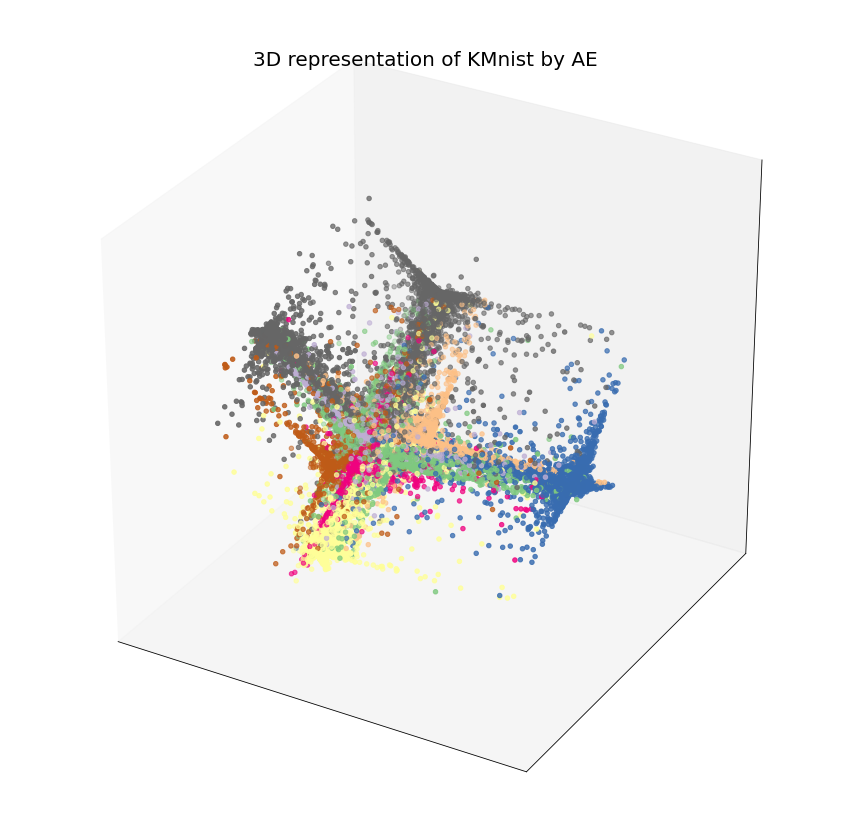

In [66]:
# plotting
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

PCA_3d_kmnist = pd.read_csv('PCA_3_dim_KMNIST.csv')

fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(1, 1, 1, projection='3d')

ax1.scatter(all_latent_3D[:, 0], all_latent_3D[:, 1], all_latent_3D[:, 2], c=y_whole_dataset, cmap='Accent')
_ = ax1.set_xticks([])
_ = ax1.set_yticks([])
_ = ax1.set_zticks([])

_ = ax1.set_title('3D representation of KMnist by AE', fontsize=20)